# Camões - Rocket Experiment Division 

Launched at EUROC'23, achieved the target apogee of 3000 meters, with a flawless ascent phase, featuring effective air brake operation throughout. 
The recovery phase had only the actuation of a drogue parachute.

Permission to use flight data given by Gonçalo Machado, 2024.

These results were extracted out of the flight card:

1. Team number: `20`
2. Launch date: `October 14th, 2023. 14h local time`
3. Last simulated apogee before flight: `3300 m` (without air brakes)
4. Official recorded apogee: `3015 m`

The relative error of altitude apogee is only `8.6%`

Note that the simulated apogee below differs from the value obtained before the flight because of upgrades made to the rocketpy software and also because the wind profile represented below differs from the one registered at the launch site. 

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from rocketpy import Function, Environment, Flight, Rocket, SolidMotor
from rocketpy import AirBrakes, _Controller
from rocketpy.motors import CylindricalTank, SolidMotor
from rocketpy.motors.tank import MassFlowRateBasedTank

import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

## Environment registered by windy


Gravity Details

Acceleration of gravity at surface level:    9.8066 m/s²
Acceleration of gravity at   4.000 km (ASL): 9.8066 m/s²


Launch Site Details

Launch Date: 2023-10-14 13:00:00 UTC | 2023-10-14 14:00:00 Portugal
Launch Site Latitude: 39.39000°
Launch Site Longitude: -8.28954°
Reference Datum: WGS84
Launch Site UTM coordinates: 44367.90 W    4373424.89 N
Launch Site UTM zone: 30S
Launch Site Surface Elevation: 107.0 m


Atmospheric Model Details

Atmospheric Model Type: Reanalysis
Reanalysis Maximum Height: 4.000 km
Reanalysis Time Period: from 2023-10-12 08:00:00 to 2023-10-15 18:00:00 utc
Reanalysis Hour Interval: 1 hrs
Reanalysis Latitude Range: From 40.0° to 39.0°
Reanalysis Longitude Range: From -9.0° to -7.0°

Surface Atmospheric Conditions

Surface Wind Speed: 207.00 m/s
Surface Wind Direction: 27.00°
Surface Wind Heading: 0.90°
Surface Pressure: 1000.00 hPa
Surface Temperature: 295.59 K
Surface Air Density: 1.179 kg/m³
Surface Speed of Sound: 344.66 m/s


Earth Model 

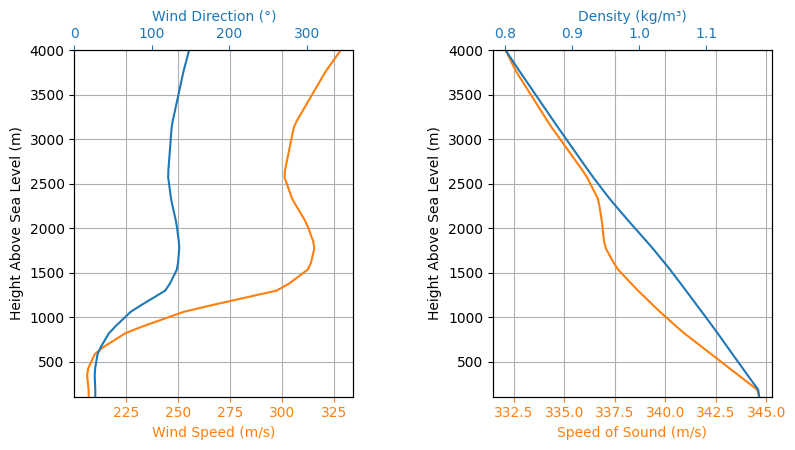

In [41]:
env = Environment(
    gravity=9.80665,
    date=(2023, 10, 14, 14),
    latitude=39.3900032043457,
    longitude=-8.2895383834838,
    elevation=107,
    datum="WGS84",
    timezone="Portugal",
)

env.set_atmospheric_model(
    type="Reanalysis",
    file="../../data/weather/euroc_2023_all_windows.nc",
    dictionary="ECMWF",
)
env.max_expected_height = 4000
env.info()

## Motor

In [96]:
Mariachi = SolidMotor(
    thrust_source="../../data/rockets/red/thrust_source.csv",
    burn_time=3.72,
    grain_number=6,
    grain_density=1637,
    grain_initial_inner_radius=0.015,
    grain_outer_radius=0.045,
    grain_initial_height=0.15,
    nozzle_radius=0.034,
    throat_radius=0.0135,
    grain_separation=0.005,
    grains_center_of_mass_position=-0.7566,
    dry_inertia=(0, 0, 0),
    center_of_dry_mass_position=0,
    dry_mass=0,
    nozzle_position=-1.3346,
)

Nozzle Details
Nozzle Radius: 0.034 m
Nozzle Throat Radius: 0.0135 m

Grain Details
Number of Grains: 6
Grain Spacing: 0.005 m
Grain Density: 1637 kg/m3
Grain Outer Radius: 0.045 m
Grain Inner Radius: 0.015 m
Grain Height: 0.15 m
Grain Volume: 0.001 m3
Grain Mass: 1.389 kg

Motor Details
Total Burning Time: 3.72 s
Total Propellant Mass: 8.331 kg
Structural Mass Ratio: 0.000
Average Propellant Exhaust Velocity: 1320.764 m/s
Average Thrust: 2957.984 N
Maximum Thrust: 4145.791 N at 1.65 s after ignition.
Total Impulse: 11003.702 Ns



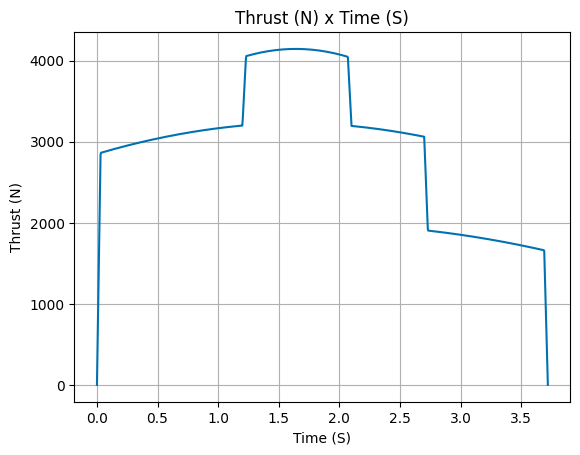

In [97]:
Mariachi.info()

## Rocket and Aerodynamic surfaces

For comparison purposes, no parachute will be added to the simulation

In [132]:
CAMOES = Rocket(
    radius=0.0715,
    mass=22.8,
    inertia=(16.2, 16.2, 0.066),
    center_of_mass_without_motor=0,
    power_off_drag="../../data/rockets/red/drag_coefficient_power_off.csv",
    power_on_drag="../../data/rockets/red/drag_coefficient_power_on.csv",
    coordinate_system_orientation="tail_to_nose",
)

CAMOES.set_rail_buttons(0.5, 0.2)

CAMOES.add_motor(Mariachi, position=0)

In [133]:
NoseCone = CAMOES.add_nose(
    length=0.455,
    kind="vonKarman",
    position=1.1884,
)

FinSet = CAMOES.add_trapezoidal_fins(
    n=4,
    span=0.155,
    root_chord=0.185,
    tip_chord=0.15,
    position=-1.0866,
)

Tail = CAMOES.add_tail(
    top_radius=0.0715, bottom_radius=0.037, length=0.048, position=-1.2866
)

In [134]:
def drogue_trigger(p, h, y):
    return True if y[5] < 5 and y[2] > 300 else False


Drogue = CAMOES.add_parachute(
    "Drogue", cd_s=0.33, sampling_rate=400, lag=1.5, trigger=drogue_trigger
)

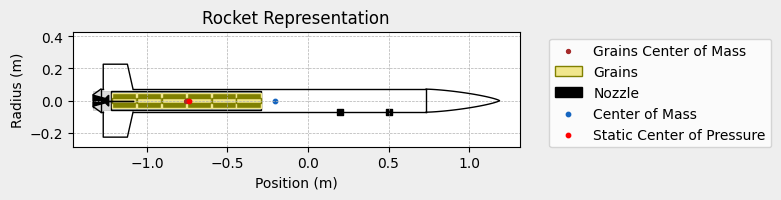

In [135]:
CAMOES.draw()

# Air Brakes - Active Control Systems

For privacy reasons, the controller function is not the one developed and used by the team. The controller used is the same as the one presented in the Airbrakes Example in RocketPy User Guide.

In [102]:
def controller_function(
    time, sampling_rate, state, state_history, observed_variables, air_brakes
):
    # state = [x, y, z, vx, vy, vz, e0, e1, e2, e3, wx, wy, wz]
    altitude_ASL = state[2]
    altitude_AGL = altitude_ASL - env.elevation
    vx, vy, vz = state[3], state[4], state[5]

    # Get winds in x and y directions
    wind_x, wind_y = env.wind_velocity_x(altitude_ASL), env.wind_velocity_y(
        altitude_ASL
    )

    # Calculate Mach number
    free_stream_speed = ((wind_x - vx) ** 2 + (wind_y - vy) ** 2 + (vz) ** 2) ** 0.5
    mach_number = free_stream_speed / env.speed_of_sound(altitude_ASL)

    # Get previous state from state_history
    previous_state = state_history[-1]
    previous_vz = previous_state[5]

    # If we wanted to we could get the returned values from observed_variables:
    # returned_time, deployment_level, drag_coefficient = observed_variables[-1]

    # Check if the rocket has reached burnout
    if time < Mariachi.burn_out_time:
        return None

    # If below 1500 meters above ground level, air_brakes are not deployed
    if altitude_AGL < 1500:
        air_brakes.deployment_level = 0

    # Else calculate the deployment level
    else:
        # Controller logic
        new_deployment_level = (
            air_brakes.deployment_level + 0.1 * vz + 0.01 * previous_vz**2
        )

        # Limiting the speed of the air_brakes to 0.2 per second
        # Since this function is called every 1/sampling_rate seconds
        # the max change in deployment level per call is 0.2/sampling_rate
        max_change = 0.2 / sampling_rate
        lower_bound = air_brakes.deployment_level - max_change
        upper_bound = air_brakes.deployment_level + max_change
        new_deployment_level = min(max(new_deployment_level, lower_bound), upper_bound)

        air_brakes.deployment_level = new_deployment_level

    # Return variables of interest to be saved in the observed_variables list
    return (
        time,
        air_brakes.deployment_level,
        air_brakes.drag_coefficient(air_brakes.deployment_level, mach_number),
    )

In [103]:
air_brakes = CAMOES.add_air_brakes(
    drag_coefficient_curve=[
        # Mach 0.1
        [0, 0.1, 0.7692],
        [10 / 100, 0.1, 0.7663],
        [20 / 100, 0.1, 0.7762],
        [30 / 100, 0.1, 0.7847],
        [40 / 100, 0.1, 0.7999],
        [50 / 100, 0.1, 0.8246],
        [60 / 100, 0.1, 0.8310],
        [70 / 100, 0.1, 0.8499],
        [80 / 100, 0.1, 0.8738],
        [90 / 100, 0.1, 0.8945],
        [100 / 100, 0.1, 1.1018],
        # Mach 0.2
        [0, 0.2, 0.7508],
        [10 / 100, 0.2, 0.7513],
        [20 / 100, 0.2, 0.7670],
        [30 / 100, 0.2, 0.7782],
        [40 / 100, 0.2, 0.7943],
        [50 / 100, 0.2, 0.8063],
        [60 / 100, 0.2, 0.8243],
        [70 / 100, 0.2, 0.8493],
        [80 / 100, 0.2, 0.8781],
        [90 / 100, 0.2, 0.8925],
        [100 / 100, 0.2, 0.9851],
        # Mach 0.3
        [0, 0.3, 0.7445],
        [10 / 100, 0.3, 0.7571],
        [20 / 100, 0.3, 0.7699],
        [30 / 100, 0.3, 0.7828],
        [40 / 100, 0.3, 0.7985],
        [50 / 100, 0.3, 0.8114],
        [60 / 100, 0.3, 0.8379],
        [70 / 100, 0.3, 0.8634],
        [80 / 100, 0.3, 0.8834],
        [90 / 100, 0.3, 0.8947],
        [100 / 100, 0.3, 0.9782],
        # Mach 0.4
        [0, 0.4, 0.7492],
        [10 / 100, 0.4, 0.7566],
        [20 / 100, 0.4, 0.7698],
        [30 / 100, 0.4, 0.7840],
        [40 / 100, 0.4, 0.7994],
        [50 / 100, 0.4, 0.8136],
        [60 / 100, 0.4, 0.8399],
        [70 / 100, 0.4, 0.8665],
        [80 / 100, 0.4, 0.8834],
        [90 / 100, 0.4, 0.8969],
        [100 / 100, 0.4, 0.9659],
        # Mach 0.5
        [0, 0.5, 0.7454],
        [10 / 100, 0.5, 0.7537],
        [20 / 100, 0.5, 0.7651],
        [30 / 100, 0.5, 0.7811],
        [40 / 100, 0.5, 0.7987],
        [50 / 100, 0.5, 0.8163],
        [60 / 100, 0.5, 0.8404],
        [70 / 100, 0.5, 0.8631],
        [80 / 100, 0.5, 0.8788],
        [90 / 100, 0.5, 0.8951],
        [100 / 100, 0.5, 0.9416],
        # Mach 0.6
        [0, 0.6, 0.7036],
        [10 / 100, 0.6, 0.7237],
        [20 / 100, 0.6, 0.7359],
        [30 / 100, 0.6, 0.7496],
        [40 / 100, 0.6, 0.7684],
        [50 / 100, 0.6, 0.7899],
        [60 / 100, 0.6, 0.8153],
        [70 / 100, 0.6, 0.8406],
        [80 / 100, 0.6, 0.8539],
        [90 / 100, 0.6, 0.8712],
        [100 / 100, 0.6, 0.9286],
        # Mach 0.7
        [0, 0.7, 0.6810],
        [10 / 100, 0.7, 0.6948],
        [20 / 100, 0.7, 0.7076],
        [30 / 100, 0.7, 0.7233],
        [40 / 100, 0.7, 0.7427],
        [50 / 100, 0.7, 0.7629],
        [60 / 100, 0.7, 0.7876],
        [70 / 100, 0.7, 0.8073],
        [80 / 100, 0.7, 0.8272],
        [90 / 100, 0.7, 0.8453],
        [100 / 100, 0.7, 0.8960],
        # Mach 0.8
        [0, 0.8, 0.6578],
        [10 / 100, 0.8, 0.6739],
        [20 / 100, 0.8, 0.6870],
        [30 / 100, 0.8, 0.7036],
        [40 / 100, 0.8, 0.7240],
        [50 / 100, 0.8, 0.7457],
        [60 / 100, 0.8, 0.7676],
        [70 / 100, 0.8, 0.7880],
        [80 / 100, 0.8, 0.8098],
        [90 / 100, 0.8, 0.8278],
        [100 / 100, 0.8, 0.8799],
        # Mach 0.9
        [0, 0.9, 0.6574],
        [10 / 100, 0.9, 0.6634],
        [20 / 100, 0.9, 0.6794],
        [30 / 100, 0.9, 0.6958],
        [40 / 100, 0.9, 0.7201],
        [50 / 100, 0.9, 0.7395],
        [60 / 100, 0.9, 0.7618],
        [70 / 100, 0.9, 0.7844],
        [80 / 100, 0.9, 0.8057],
        [90 / 100, 0.9, 0.8278],
        [100 / 100, 0.9, 0.8628],
        # Mach 1.0
        [0, 1.0, 0.8350],
        [10 / 100, 1.0, 0.8241],
        [20 / 100, 1.0, 0.8403],
        [30 / 100, 1.0, 0.8593],
        [40 / 100, 1.0, 0.8832],
        [50 / 100, 1.0, 0.9070],
        [60 / 100, 1.0, 0.9358],
        [70 / 100, 1.0, 0.9639],
        [80 / 100, 1.0, 0.9881],
        [90 / 100, 1.0, 1.0093],
        [100 / 100, 1.0, 1.0347],
        # Mach 1.1
        [0, 1.1, 0.8610],
        [10 / 100, 1.1, 0.8447],
        [20 / 100, 1.1, 0.8617],
        [30 / 100, 1.1, 0.8800],
        [40 / 100, 1.1, 0.9027],
        [50 / 100, 1.1, 0.9244],
        [60 / 100, 1.1, 0.9515],
        [70 / 100, 1.1, 0.9810],
        [80 / 100, 1.1, 1.0069],
        [90 / 100, 1.1, 1.0253],
        [100 / 100, 1.1, 1.0560],
    ],
    controller_function=controller_function,
    sampling_rate=10,
    reference_area=None,
    clamp=True,
    initial_observed_variables=(0, 0, 0),
    override_rocket_drag=True,
    name="Air Brakes",
)

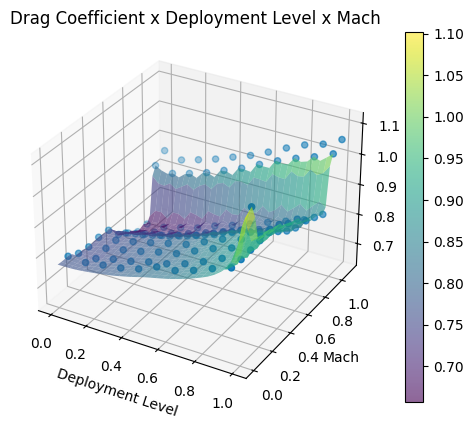

In [104]:
air_brakes.all_info()

## Flight Simulation Data

In [105]:
test_flight = Flight(
    rocket=CAMOES, environment=env, inclination=84, heading=133, rail_length=12
)

R:\RocketPy\rocketpy\simulation\flight.py:1201: UserWarning: time_overshoot has been set to False due to the presence of controllers or sensors. 
  warnings.warn(



Apogee State

Apogee Time: 23.581 s
Apogee Altitude: 3287.172 m (ASL) | 3180.172 m (AGL)
Apogee Freestream Speed: 16.592 m/s
Apogee X position: 421.526 m
Apogee Y position: -483.418 m
Apogee latitude: 39.3856546°
Apogee longitude: -8.2846325°


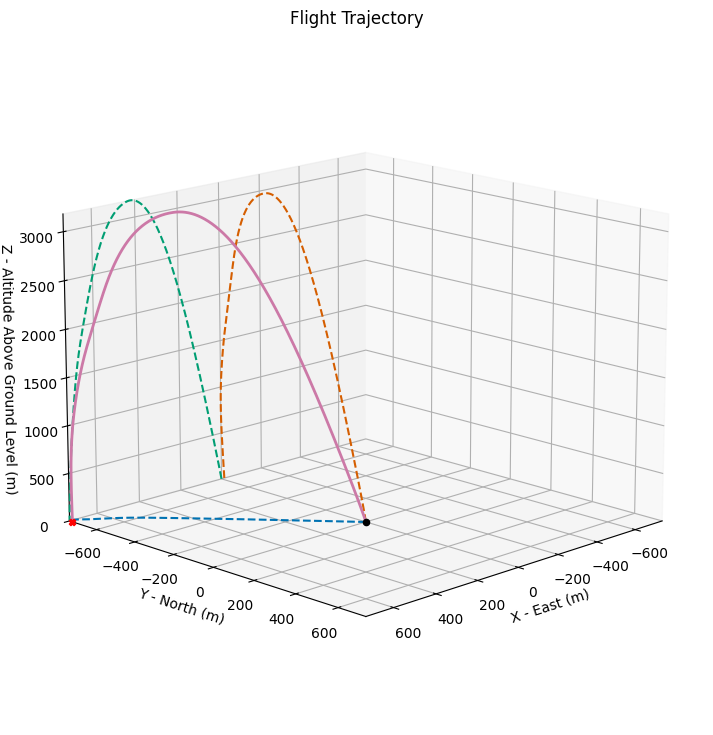

In [106]:
test_flight.prints.apogee_conditions()
test_flight.plots.trajectory_3d()

## Data analysis

In [107]:
from rocketpy.simulation.flight_data_importer import FlightDataImporter

In [108]:
columns_map = {
    "ts": "time",
    "filtered_altitude_AGL": "altitude",
    "filtered_acceleration": "az",
}

cots_altimeter_flight = FlightDataImporter(
    name="COTS Altimeter Flight",
    paths="../../data/rockets/red/flight_data.csv",
    columns_map=columns_map,
    units=None,
    interpolation="linear",
    extrapolation="zero",
    delimiter=",",
    encoding="utf-8",
)

The following attributes were create and are now available to be used:  ['time', 'altitude', 'az']


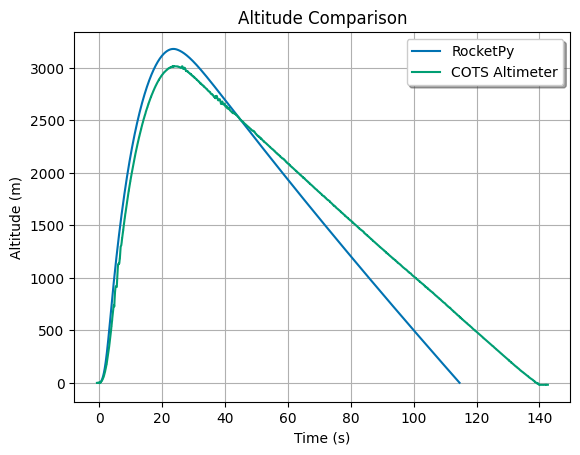

In [109]:
Function.compare_plots(
    [
        (test_flight.altitude, "RocketPy"),
        (cots_altimeter_flight.altitude, "COTS Altimeter"),
    ],
    title="Altitude Comparison",
    xlabel="Time (s)",
    ylabel="Altitude (m)",
)

In [110]:
columns_map = {
    "ts": "time",
    "latitude": "latitude",
    "longitude": "longitude",
}

cots_gnss_flight = FlightDataImporter(
    name="COTS GNSS Flight",
    paths="../../data/rockets/red/gnss_flight.csv",
    columns_map=columns_map,
    units=None,
    interpolation="linear",
    extrapolation="zero",
    delimiter=",",
    encoding="utf-8",
)

The following attributes were create and are now available to be used:  ['time', 'latitude', 'longitude']


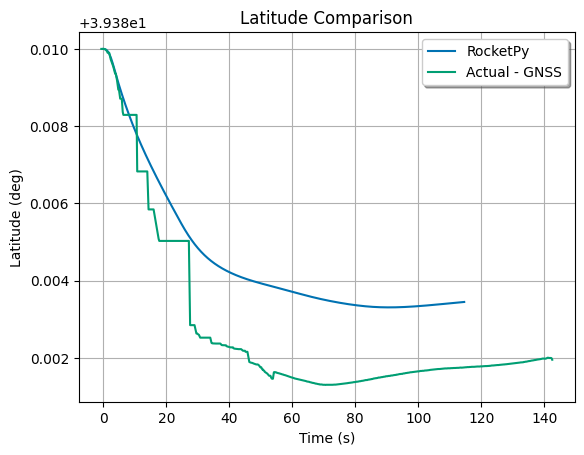

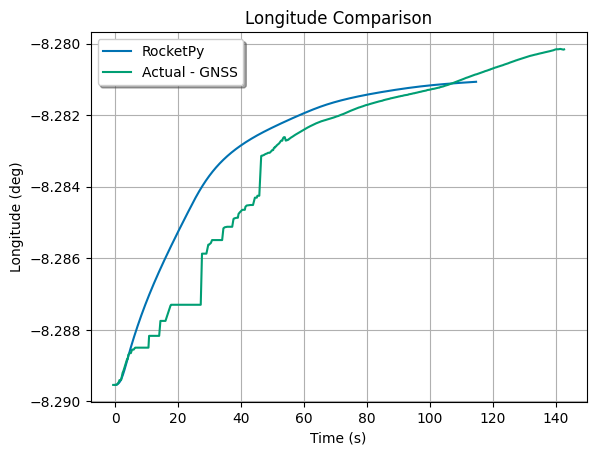

In [111]:
Function.compare_plots(
    [(test_flight.latitude, "RocketPy"), (cots_gnss_flight.latitude, "Actual - GNSS")],
    title="Latitude Comparison",
    xlabel="Time (s)",
    ylabel="Latitude (deg)",
)
Function.compare_plots(
    [
        (test_flight.longitude, "RocketPy"),
        (cots_gnss_flight.longitude, "Actual - GNSS"),
    ],
    title="Longitude Comparison",
    xlabel="Time (s)",
    ylabel="Longitude (deg)",
)